# Assignment 7

**Group Members** 

- *Deepansh Pandey*
- *Swaroop Bhandary*

In [8]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn import Parameter

In [9]:
'''
STEP 1: LOADING DATASET
'''
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
 
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [10]:
'''
STEP 2: MAKING DATASET ITERABLE
'''
 
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

torch.manual_seed(33)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(33)

# Long Short Term Memory

**Reference - http://mlexplained.com/2019/02/15/building-an-lstm-from-scratch-in-pytorch-lstms-in-depth-part-1/**

In [11]:
class LSTMCell(nn.Module):
    '''
    Class to implement the operation of single LSTM cell
    '''
    def __init__(self, input_dim, hidden_dim):
        super(LSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.weight_ih = Parameter(torch.Tensor(input_dim, hidden_dim * 4)) # weight matrix from input to hidden layer
        self.weight_hh = Parameter(torch.Tensor(hidden_dim, hidden_dim * 4)) # weight matrix from ht-1 to ht
        self.bias = Parameter(torch.Tensor(hidden_dim * 4))
        self.init_weights()
     
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
         
    def forward(self, x, init_states):      
        
        h_t, c_t = init_states
        x_t = x.view(-1, x.size(1))
        
        # batch the computations into a single matrix multiplication
        gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias 

        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4,1) 


        input_gate = torch.sigmoid(input_gate)
        forget_gate = torch.sigmoid(forget_gate)
        cell_gate = torch.tanh(cell_gate)
        output_gate = torch.sigmoid(output_gate)
        
        c_t = forget_gate * c_t + input_gate * cell_gate
        h_t = output_gate * torch.tanh(c_t)
               
        return h_t, c_t

In [12]:
class OptimizedLSTM(nn.Module):
    '''
    Class to implement the output of last LSTM layer in Fully Connected Layer
    '''
    def __init__ (self, input_dim, hidden_dim, layer_dim, output_dim):
        super(OptimizedLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstmcell = LSTMCell(input_dim, hidden_dim) 
        self.layer_dim = layer_dim
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        #print(x.shape,"x.shape")100, 28, 28
        if torch.cuda.is_available():
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda()
        else:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
         
        # Initialize cell state
        if torch.cuda.is_available():
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda()
        else:
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
         
        cn = c0[0,:,:]
        hn = h0[0,:,:]
        h_t_all = [] # Output of all 28 ht in it
        
        for seq in range(x.size(1)):
            hn, cn = self.lstmcell(x[:,seq,:], (hn,cn)) 
            h_t_all.append(hn)
    
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(h_t_all[-1]) 
        # out.size() --> 100, 10

        return out

In [13]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 100
layer_dim = 1  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10 

model = OptimizedLSTM(input_dim, hidden_dim, layer_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
 
if torch.cuda.is_available():
    model.cuda()
    
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()
 
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1
 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [14]:
'''
STEP 7: TRAIN THE MODEL
'''
 
# Number of steps to unroll
seq_dim = 28 
 
loss_lstm = []
accuracy_lstm = []    
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = images.view(-1, seq_dim, input_dim).cuda()
            labels = labels.cuda()
        else:
            images = images.view(-1, seq_dim, input_dim)

             
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
         
        iter += 1
         
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = images.view(-1, seq_dim, input_dim).cuda()

                 
                # Forward pass only to get logits/output
                outputs = model(images)
                 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                 
                # Total number of labels
                total += labels.size(0)
                 
                # Total correct predictions
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
             
            accuracy = 100 * correct / total
             
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            loss_lstm.append(loss.item())
            accuracy_lstm.append(accuracy)

Iteration: 500. Loss: 2.2599470615386963. Accuracy: 19
Iteration: 1000. Loss: 0.717487096786499. Accuracy: 71
Iteration: 1500. Loss: 0.3671528697013855. Accuracy: 87
Iteration: 2000. Loss: 0.21650680899620056. Accuracy: 92
Iteration: 2500. Loss: 0.2049739956855774. Accuracy: 94
Iteration: 3000. Loss: 0.038493383675813675. Accuracy: 96
Iteration: 3500. Loss: 0.10298143327236176. Accuracy: 96
Iteration: 4000. Loss: 0.13552288711071014. Accuracy: 96
Iteration: 4500. Loss: 0.0694621354341507. Accuracy: 97
Iteration: 5000. Loss: 0.21357440948486328. Accuracy: 97
Iteration: 5500. Loss: 0.05332742631435394. Accuracy: 97
Iteration: 6000. Loss: 0.14658819139003754. Accuracy: 97


# Gated Recurrent Unit

**Reference - https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be**

In [15]:
class GRUCell(nn.Module):
    '''
    Class to implement the operation of single LSTM cell
    '''
    def __init__(self, input_dim, hidden_dim):
        super(GRUCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.weight_ih = Parameter(torch.Tensor(input_dim, hidden_dim * 3)) # weight matrix from input to hidden layer
        self.weight_hh = Parameter(torch.Tensor(hidden_dim, hidden_dim * 3)) # weight matrix from ht-1 to ht
        self.bias = Parameter(torch.Tensor(hidden_dim * 3))
        self.init_weights()
     
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
         
    def forward(self, x, init_states):      
        
        h_t = init_states
        x_t = x.view(-1, x.size(1))
        
        # batch the computations into a single matrix multiplication
        gates_x = x_t @ self.weight_ih + self.bias 
        gates_h = h_t @ self.weight_hh + self.bias 

        x_reset_gate, x_update_gate, x_curr_memory_gate = gates_x.chunk(3, 1)
        h_reset_gate, h_update_gate, h_curr_memory_gate = gates_h.chunk(3, 1)



        reset_gate = torch.sigmoid(x_reset_gate + h_reset_gate)
        update_gate = torch.sigmoid(x_update_gate + h_update_gate)
        curr_memory_gate = torch.tanh( x_curr_memory_gate + (reset_gate * h_curr_memory_gate) )
        
        h_t = curr_memory_gate + update_gate * (h_t - curr_memory_gate)
               
        return h_t

In [16]:
class OptimizedGRU(nn.Module):
    '''
    Class to implement the output of last LSTM layer in Fully Connected Layer
    '''
    def __init__ (self, input_dim, hidden_dim, layer_dim, output_dim):
        super(OptimizedGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.grucell = GRUCell(input_dim, hidden_dim) 
        self.layer_dim = layer_dim
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        #print(x.shape,"x.shape")100, 28, 28
        if torch.cuda.is_available():
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda()
        else:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
         
        # Initialize cell state
        if torch.cuda.is_available():
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda()
        else:
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
         
        hn = h0[0,:,:]
        h_t_all = [] # Output of all 28 ht in it
        
        for seq in range(x.size(1)):
            hn = self.grucell(x[:,seq,:], hn) 
            h_t_all.append(hn)
    
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(h_t_all[-1]) 
        # out.size() --> 100, 10

        return out

In [17]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 100
layer_dim = 1  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10 

model = OptimizedGRU(input_dim, hidden_dim, layer_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
 
if torch.cuda.is_available():
    model.cuda()
    
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()
 
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1
 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [18]:
'''
STEP 7: TRAIN THE MODEL
'''
 
# Number of steps to unroll
seq_dim = 28 
loss_gru = []
accuracy_gru = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = images.view(-1, seq_dim, input_dim).cuda()
            labels = labels.cuda()
        else:
            images = images.view(-1, seq_dim, input_dim)

             
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
         
        iter += 1
         
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = images.view(-1, seq_dim, input_dim).cuda()

                 
                # Forward pass only to get logits/output
                outputs = model(images)
                 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                 
                # Total number of labels
                total += labels.size(0)
                 
                # Total correct predictions
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
             
            accuracy = 100 * correct / total
             
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            loss_gru.append(loss.item())
            accuracy_gru.append(accuracy)

Iteration: 500. Loss: 1.055217981338501. Accuracy: 63
Iteration: 1000. Loss: 0.3578762710094452. Accuracy: 81
Iteration: 1500. Loss: 0.20232348144054413. Accuracy: 92
Iteration: 2000. Loss: 0.17758136987686157. Accuracy: 95
Iteration: 2500. Loss: 0.1312677562236786. Accuracy: 96
Iteration: 3000. Loss: 0.09520073235034943. Accuracy: 96
Iteration: 3500. Loss: 0.04772904887795448. Accuracy: 97
Iteration: 4000. Loss: 0.027810582891106606. Accuracy: 97
Iteration: 4500. Loss: 0.027865510433912277. Accuracy: 97
Iteration: 5000. Loss: 0.10011614114046097. Accuracy: 97
Iteration: 5500. Loss: 0.17754165828227997. Accuracy: 97
Iteration: 6000. Loss: 0.02110672928392887. Accuracy: 97


# Visualization

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [30]:
data_loss = pd.DataFrame({'x': np.arange(500,6500,500), 'LSTM': loss_lstm, 'GRU': loss_gru})

Text(0, 0.5, 'Loss')

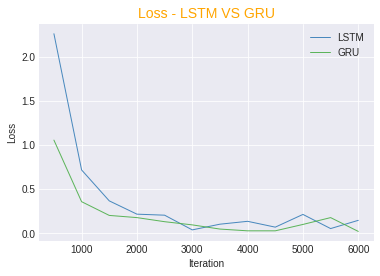

In [32]:
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in data_loss.drop('x', axis=1):
    num+=1
    plt.plot(data_loss['x'], data_loss[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column) 
# Add legend
plt.legend()
 
# Add titles
plt.title("Loss - LSTM VS GRU", loc='center', fontsize=14, fontweight=0, color='orange')
plt.xlabel("Iteration")
plt.ylabel("Loss")


In [49]:
accuracy_lstm_upd = [] 
accuracy_gru_upd = [] 
for i in range(12):
    accuracy_lstm_upd.append(accuracy_lstm[i].item())
    accuracy_gru_upd.append(accuracy_gru[i].item())

In [50]:
data_accuracy = pd.DataFrame({'x': np.arange(500,6500,500), 'LSTM': accuracy_lstm_upd, 'GRU': accuracy_gru_upd})

Text(0, 0.5, 'Accuracy')

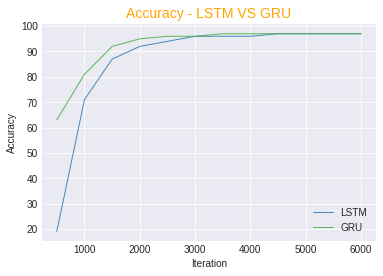

In [53]:
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in data_accuracy.drop('x', axis=1):
    num+=1
    plt.plot(data_accuracy['x'], data_accuracy[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column) 
# Add legend
plt.legend()
 
# Add titles
plt.title("Accuracy - LSTM VS GRU", loc='center', fontsize=14, fontweight=0, color='orange')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")